# Example: Regrid from Native FV3 Vertical Grid to Pressure Levels

See documentation about the FV3 native grid [here](https://repository.library.noaa.gov/view/noaa/30725), in Section 5.1.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import fsspec

from ufs2arco import Layers2Pressure

## Open GRIB2 file from Replay

The Replay dataset contains Grib2 files with fields interpolated to pressure levels via the [NCEP Unified Post Processor](https://github.com/NOAA-EMC/UPP).
We will use this as a verification, grabbing a random date from the 1 degree dataset.

In [2]:
url = "filecache::s3://noaa-ufs-gefsv13replay-pds/1deg/1996/01/1996010106/GFSPRS.GrbF00"
file = fsspec.open_local(url, s3={"anon": True}, filecache={"cache_storage": "./gribcache"})

In [3]:
gds = xr.open_dataset(
    file,
    engine="cfgrib",
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
)
gds = gds.rename({"isobaricInhPa": "level"})

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/cfgrib/dataset.py", line 721, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/contrib2/Tim.Smith/miniconda3/envs/graphufs-cpu2/lib/python3.11/site-packages/cfgrib/dataset.py", line 639, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,
        775.,  750.,  725.,  700.,  675.,  650.,  625.,  600.,  575.,
        550.,  525.,  500.,  475.,  450.,  425.,  400.,  375.,  350.,
        325.,  300.,  275.,  250.,  225.,  200.,  175.,  150.,  125.,
        100.,   70.,   50.,   40.,   30.,   20.,   15.,   10.,    7.,
          5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobari

## Pull same data from our zarr store on GCS

Note that there will be some expected differences since the order of operations is different.
The fields in the Grib2 files are first interpolated vertically to pressure levels, then horizontally from cubed sphere to the Gaussian grid.
Whereas our Replay dataset on GCS is already on the Gaussian grid, and we will interpolate this to pressure levels.

In [4]:
ds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/1.00-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

ds = ds[["tmp", "pressfc", "delz", "dpres", "spfh", "ugrd", "vgrd", "dzdt"]]
ds = ds.sel(time=gds.time.values).load()
ds = ds.rename({"pfull": "level", "grid_xt": "longitude", "grid_yt": "latitude"})

### Create Layers2Pressure object

This handles all the calculations

In [5]:
lp = Layers2Pressure()

Compute layer mean pressure, and get the interpolation coefficients to interpolate to 850 hPa.

Note that it's convenient to pre-calculate these coefficients, in order to re-use these for interpolating multiple variables.

In [6]:
prsl = lp.calc_layer_mean_pressure(ds["pressfc"], ds["tmp"], ds["spfh"], ds["delz"])

In [7]:
pstar = 850 # hPa
pstar *= 100 # Pa
cds = lp.get_interp_coefficients(pstar, prsl)

In [8]:
pressure_fields = {}
for key in ["tmp", "spfh", "ugrd", "vgrd", "dzdt"]:
    pressure_fields[key] = lp.interp2pressure(
        ds[key],
        pstar=pstar,
        prsl=prsl,
        cds=cds,
    )

In [9]:
replay2grib = {
    "tmp": "t",
    "spfh": "q",
    "ugrd": "u",
    "vgrd": "v",
    "dzdt": "wz",
}

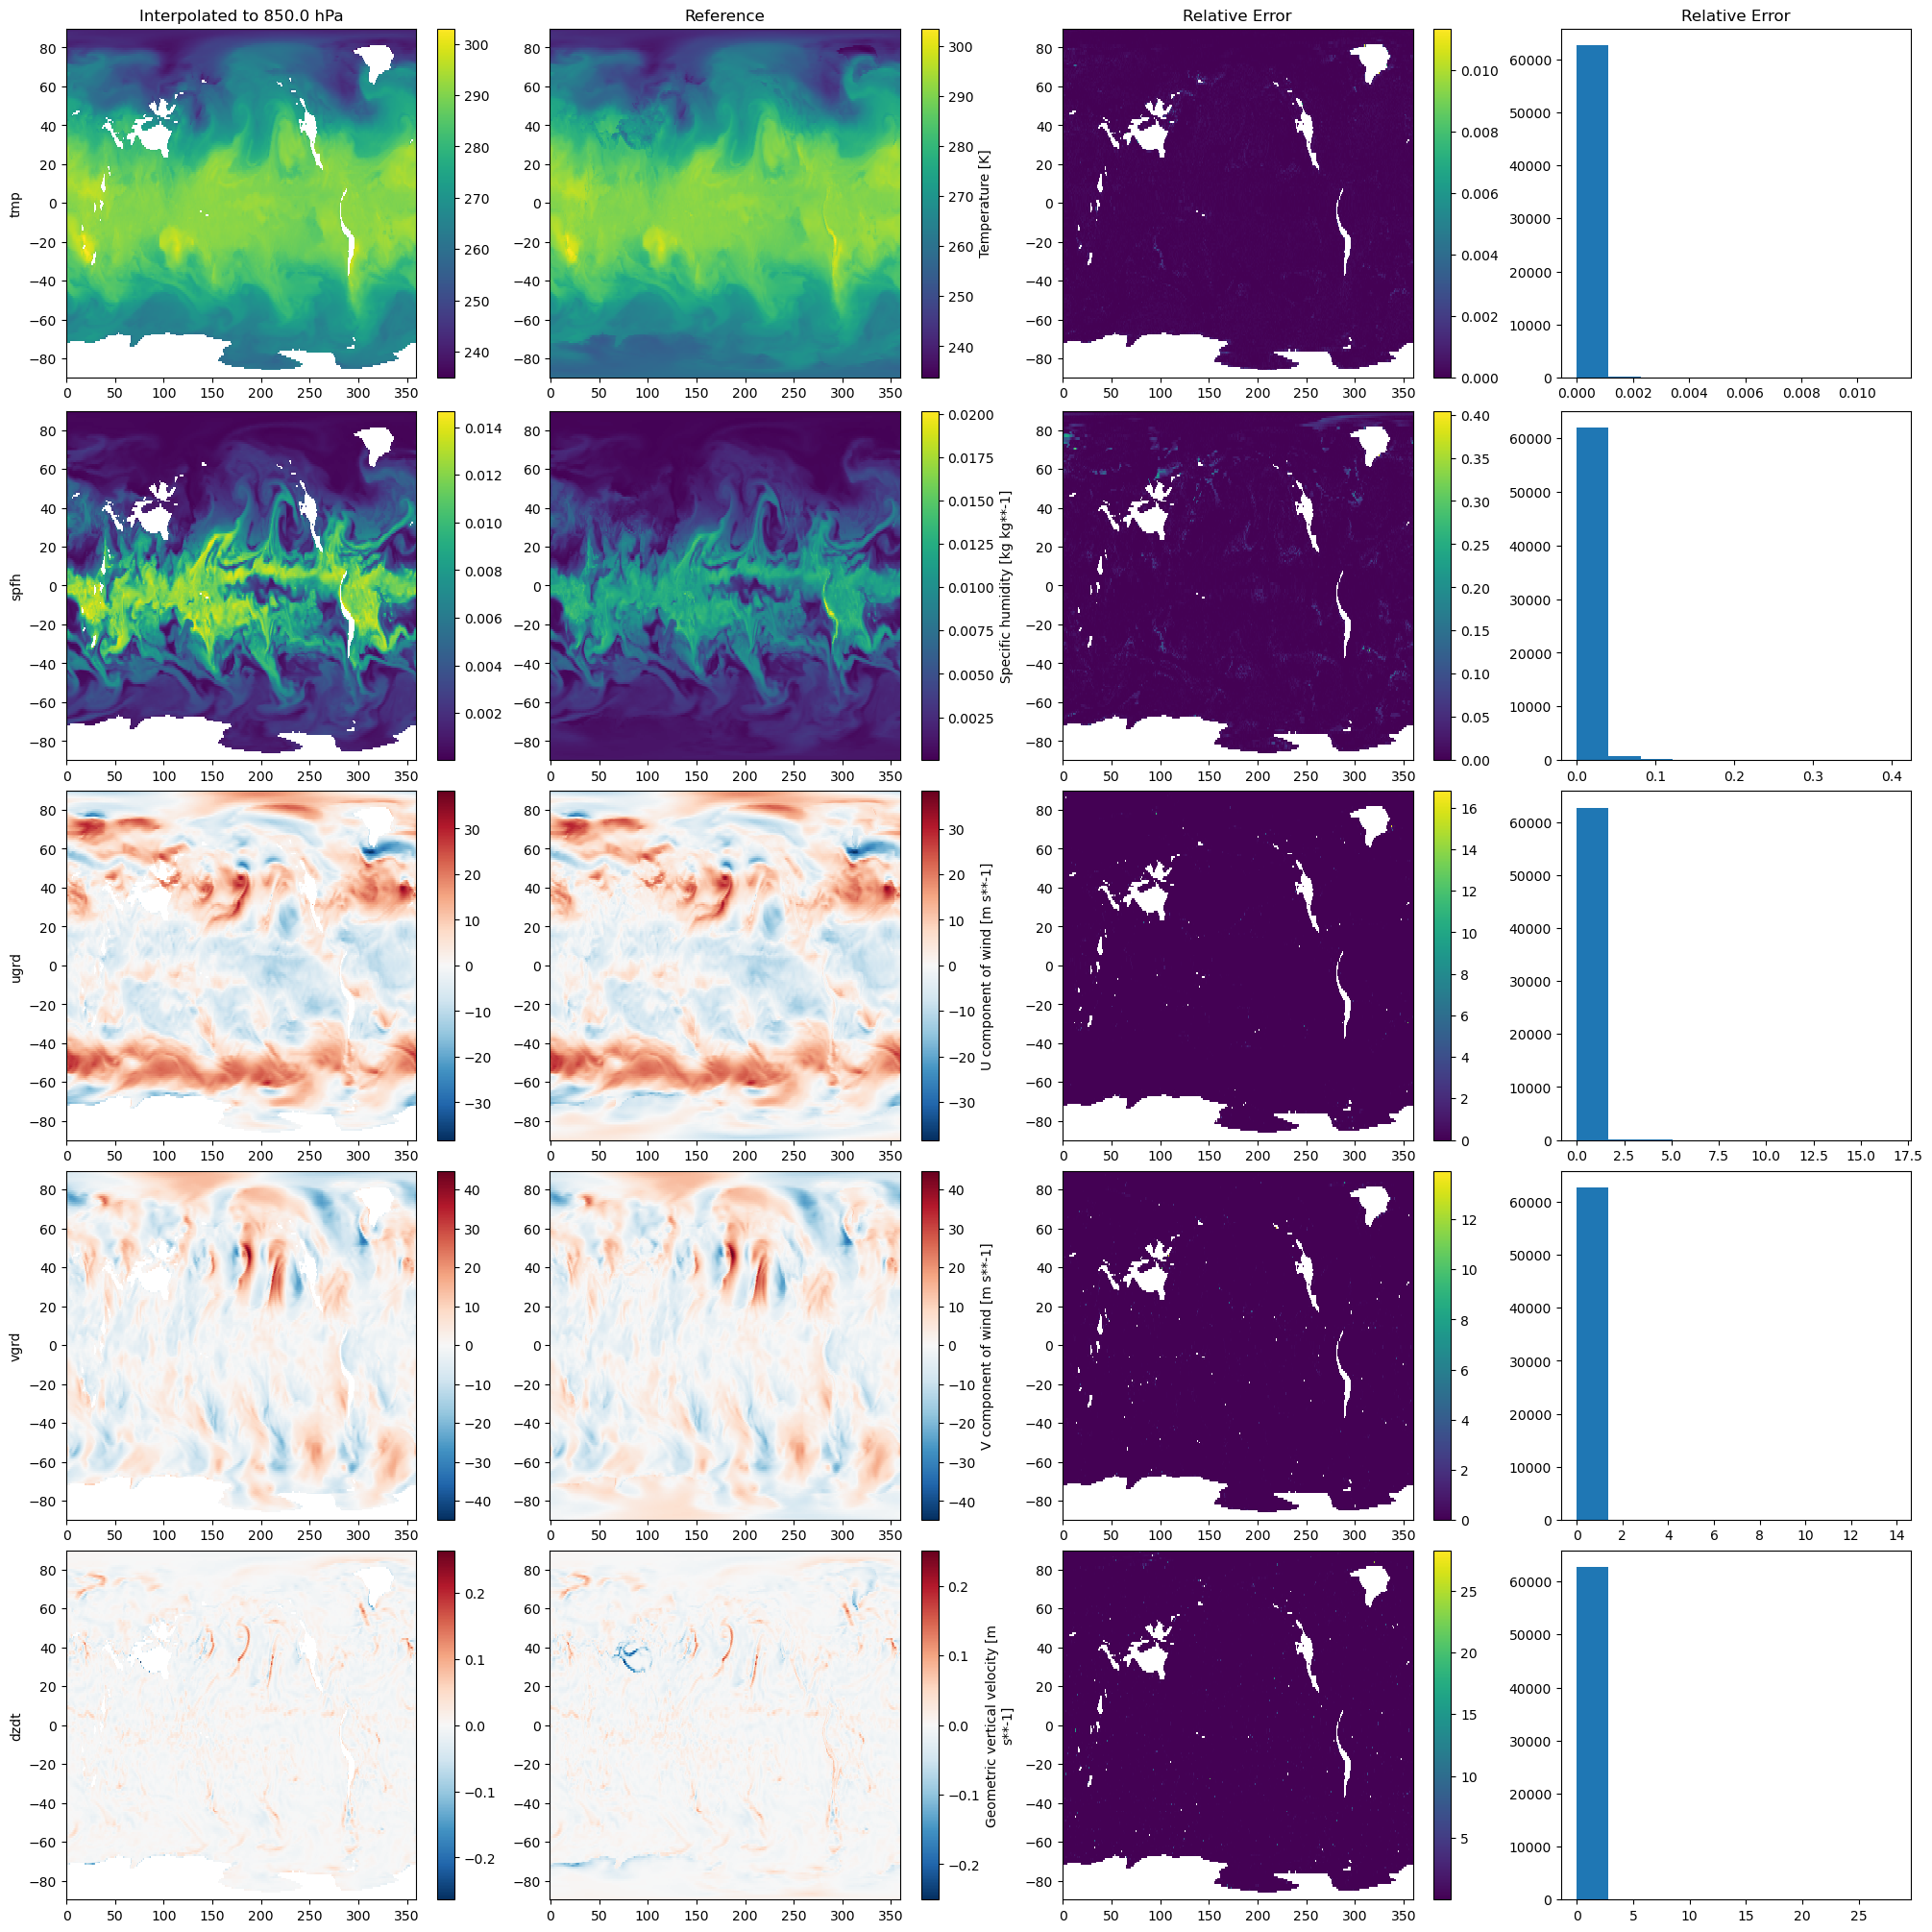

In [10]:
nrows = len(pressure_fields)
fig, axs = plt.subplots(nrows, 4, figsize=(20, 4*nrows), constrained_layout=True)

for (key, xda), axr in zip(pressure_fields.items(), axs):

    gxda = gds[replay2grib[key]].sel(level=pstar/100)
    diff = xda - gxda
    denom = np.abs(gxda)
    denom = denom.where(denom > 1e-6, np.nan)
    reldiff = np.abs(diff) / denom

    xda.plot(ax=axr[0])
    gxda.plot(ax=axr[1])
    reldiff.plot(ax=axr[2])
    reldiff.plot.hist(ax=axr[3])
    [ax.set(xlabel="", ylabel="", title="") for ax in axr]
    axr[0].set(ylabel=key)

axs[0,0].set(title=f"Interpolated to {pstar/100} hPa")
axs[0,1].set(title="Reference")
axs[0,2].set(title="Relative Error")
axs[0,3].set(title="Relative Error");

Note that we do not extrapolate the field below the surface. Instead these points are ignored and replaced with NaNs.